In [41]:
# Librerias necesarias
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
#from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from datetime import datetime
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Resizing, UpSampling2D
from tensorflow.keras.layers import  Flatten, Dense,BatchNormalization,MultiHeadAttention, LayerNormalization, Permute, Add,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam
from skimage import exposure
from PIL import Image
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt


In [42]:

# Define las rutas a las carpetas
base_dir = 'dataset'
categorias = ['benigno', 'maligno']

datos = []
etiquetas = []
desviacion_estandar_antes = []
desviacion_estandar_despues = []

In [43]:
image_path = "c:\\Users\\andre\\Documents\\Semillero\\dataset\\normal\\imagenmdb_1220.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224,224), interpolation=cv2.INTER_LINEAR)

In [44]:
def img_compar(img_original, img_preprocess):
    # Mostrar la imagen original y la imagen preprocesada
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title('Imagen Original')
    plt.axis('on')

    plt.subplot(1, 2, 2)
    plt.imshow(img_preprocess, cmap='gray')
    plt.title('Imagen Preprocesada')
    plt.axis('on')

    plt.show()

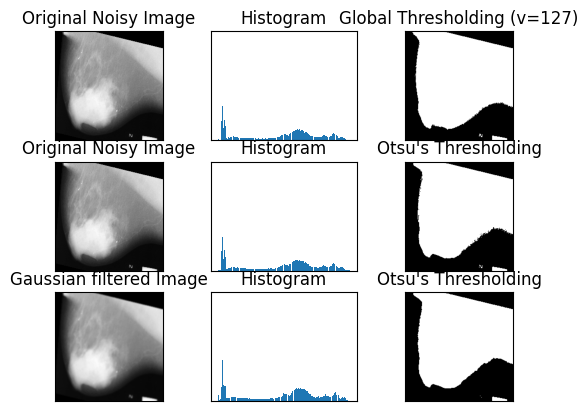

In [45]:
# global thresholding
ret1,th1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
 img, 0, th2,
 blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
 'Original Noisy Image','Histogram',"Otsu's Thresholding",
 'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
 plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
 plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
 plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
 plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
 plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

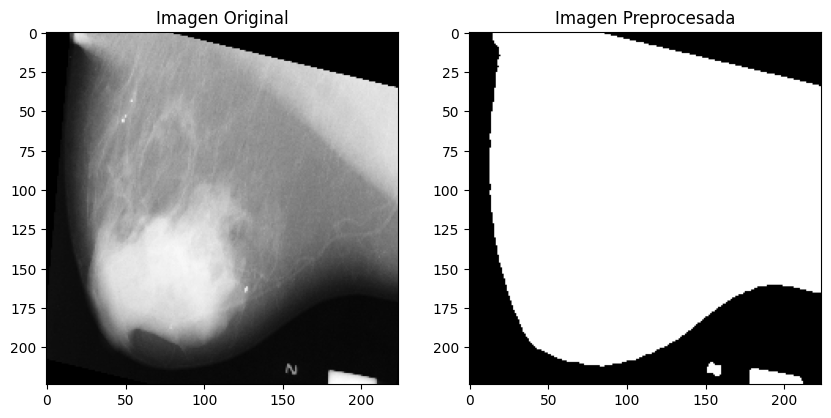

In [46]:
def gaussian_and_tresholdA(img, gaussian_kernel_size=(5,5),adaptive_thresh_blocksize=11, adaptive_thresh_C=2):
    # Aplicar un filtro gaussiano para suavizar la imagen
    blurred = cv2.GaussianBlur(img, gaussian_kernel_size, 0)
    
    # Aplicar umbralización adaptativa para resaltar las regiones de interés
    #adaptive_threshold = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              # cv2.THRESH_BINARY_INV, adaptive_thresh_blocksize, adaptive_thresh_C)
    #_, otsu_threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    _,th1 = cv2.threshold(blurred,25,255,cv2.THRESH_BINARY)

    return th1

gaus_thres_img = gaussian_and_tresholdA(img)

img_compar(img,gaus_thres_img)
                                               

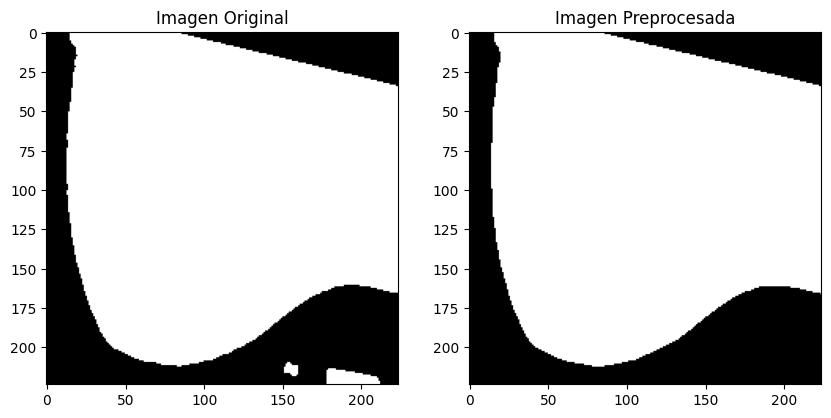

In [47]:
def filter_morph_close(img,morph_kernel_size=(30,30)):
    # Aplicar operación morfológica para eliminar pequeños artefactos
    morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    
    morphed = cv2.morphologyEx(img, cv2.MORPH_OPEN, morph_kernel)
    #morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, morph_kernel)

    return morphed

morphed_img = filter_morph_close(gaus_thres_img)

img_compar(gaus_thres_img,morphed_img)

numero de componentes:  2
labels img:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
unique components:  [0 1]
counts :  [13780 36396]
fondo:  13780
componente mas grande:  1


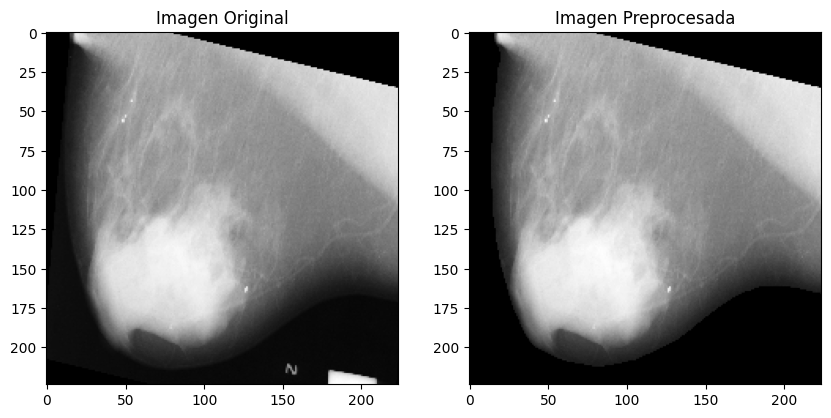

In [48]:
def nose(morphed,adaptive_threshold,original):
     # Encontrar todos los componentes conectados
    num_labels, labels_im = cv2.connectedComponents(morphed)

    print("numero de componentes: ",num_labels)
    print("labels img: ",labels_im)
    
    # Eliminar componentes conectados pequeños (asumimos que el seno es el componente más grande)
    unique, counts = np.unique(labels_im, return_counts=True)

    print("unique components: ",unique)
    print("counts : ",counts)
    print("fondo: " ,counts[0])
    # Ignorar el fondo
    counts[0] = 0
    
    # Encontrar el componente más grande
    max_label = unique[np.argmax(counts)]

    print("componente mas grande: ",max_label)
    
    # Crear una máscara solo con el componente más grande
    cleaned_background = np.zeros(adaptive_threshold.shape, np.uint8)

    cleaned_background[labels_im == max_label] = 255
    
    # Aplicar la máscara para mantener solo el objeto principal
    cleaned_image = cv2.bitwise_and(original, original, mask=cleaned_background)

    return cleaned_image

nose_img = nose(morphed_img,gaus_thres_img,img)

img_compar(img,nose_img)



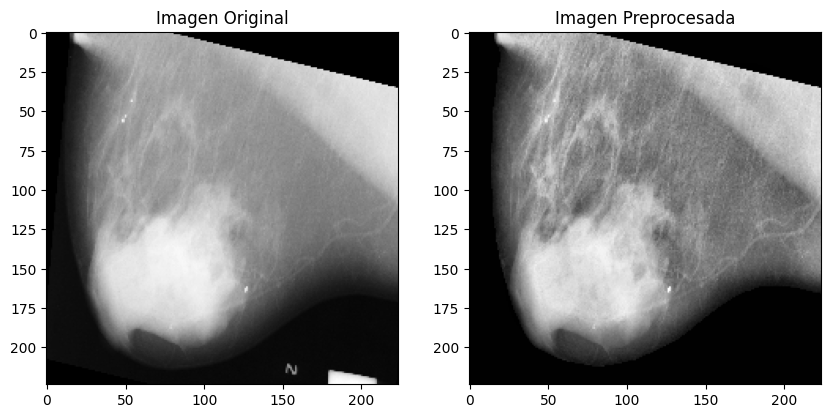

In [49]:

def aplicar_clahe(img):
    # Aplicar CLAHE para mejorar el contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    final_image = clahe.apply(img)
    return final_image

clahe_img = aplicar_clahe(nose_img)

img_compar(img,clahe_img)

In [50]:
import os
import tensorflow as tf
import cv2

def image_processor(image_path, target_size, base_directory="c:\\Users\\andre\\Documents\\Semillero\\dataset"):
    """Preprocess images for Inception V3 model with Gaussian filter and CLAHE"""

    absolute_image_path = os.path.abspath(image_path)

    # Count for skipped and processed images
    skipped_count = 0
    processed_count = 0

    # Check if the image path starts with the specified directory
    if not absolute_image_path.startswith(base_directory):
        skipped_count += 1
        print(f"La ruta {absolute_image_path} no comienza con {base_directory}")
        return None, skipped_count, processed_count
    
    # Read the image using TensorFlow for GPU acceleration
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1)  # Leer en escala de grises
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Resize the image
    image = tf.image.resize(image, (target_size[0], target_size[1]))

    # Convertir la imagen de TensorFlow a formato de 8 bits sin signo
    image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    image_numpy = image_uint8.numpy()

    
    threshold_img = gaussian_and_tresholdA(image_numpy)
    morphology = filter_morph_close(threshold_img)
    cleaned_img = nose(morphology,threshold_img,image_numpy)
    #clahe_img = aplicar_clahe(cleaned_img)
    
    

    # Convertir de nuevo a formato de TensorFlow y normalizar
    image_usm_tf = tf.convert_to_tensor(cleaned_img, dtype=tf.float32) / 255.0

    processed_count += 1

    # Obtener la etiqueta desde el nombre de la subcarpeta
    if os.path.basename(os.path.dirname(image_path)) == 'normal':
        label = 0
    elif os.path.basename(os.path.dirname(image_path)) == 'benigno':
        label = 1
    elif os.path.basename(os.path.dirname(image_path)) == 'maligno':
        label = 2
    else:
        label = -1  # Etiqueta para casos no definidos

    return image_usm_tf, label, skipped_count, processed_count

In [51]:


# Directorio base para las imágenes
base_directory = "dataset"

# Lista para almacenar las imágenes procesadas y sus etiquetas
image_data = []
labels = []

# Lista de subcarpetas que deseas procesar
subfolders_to_process = ["benigno", "maligno"]

# Iterar sobre las subcarpetas especificadas
for subfolder in subfolders_to_process:
    subfolder_path = os.path.join(base_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Iterar sobre las imágenes en la subcarpeta actual
        for image_name in os.listdir(subfolder_path):
            # Construir la ruta completa de la imagen
            image_path = os.path.join(subfolder_path, image_name)
            # Procesar la imagen y obtener la etiqueta
            image, label, skipped, process = image_processor(image_path, target_size=(224, 224))
            if image is not None:
                image_data.append(image)
                labels.append(label)

print(f"Se procesaron {len(image_data)} imágenes")


numero de componentes:  2
labels img:  [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
unique components:  [0 1]
counts :  [24048 26128]
fondo:  24048
componente mas grande:  1
numero de componentes:  2
labels img:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
unique components:  [0 1]
counts :  [36212 13964]
fondo:  36212
componente mas grande:  1
numero de componentes:  2
labels img:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
unique components:  [0 1]
counts :  [36212 13964]
fondo:  36212
componente mas grande:  1
numero de componentes:  2
labels img:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
unique components:  [0 1]
counts :  [36212 13964]
fondo:  36212
componente mas grande:  1
nume

In [52]:
print(labels)
print(image_data[0].shape)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

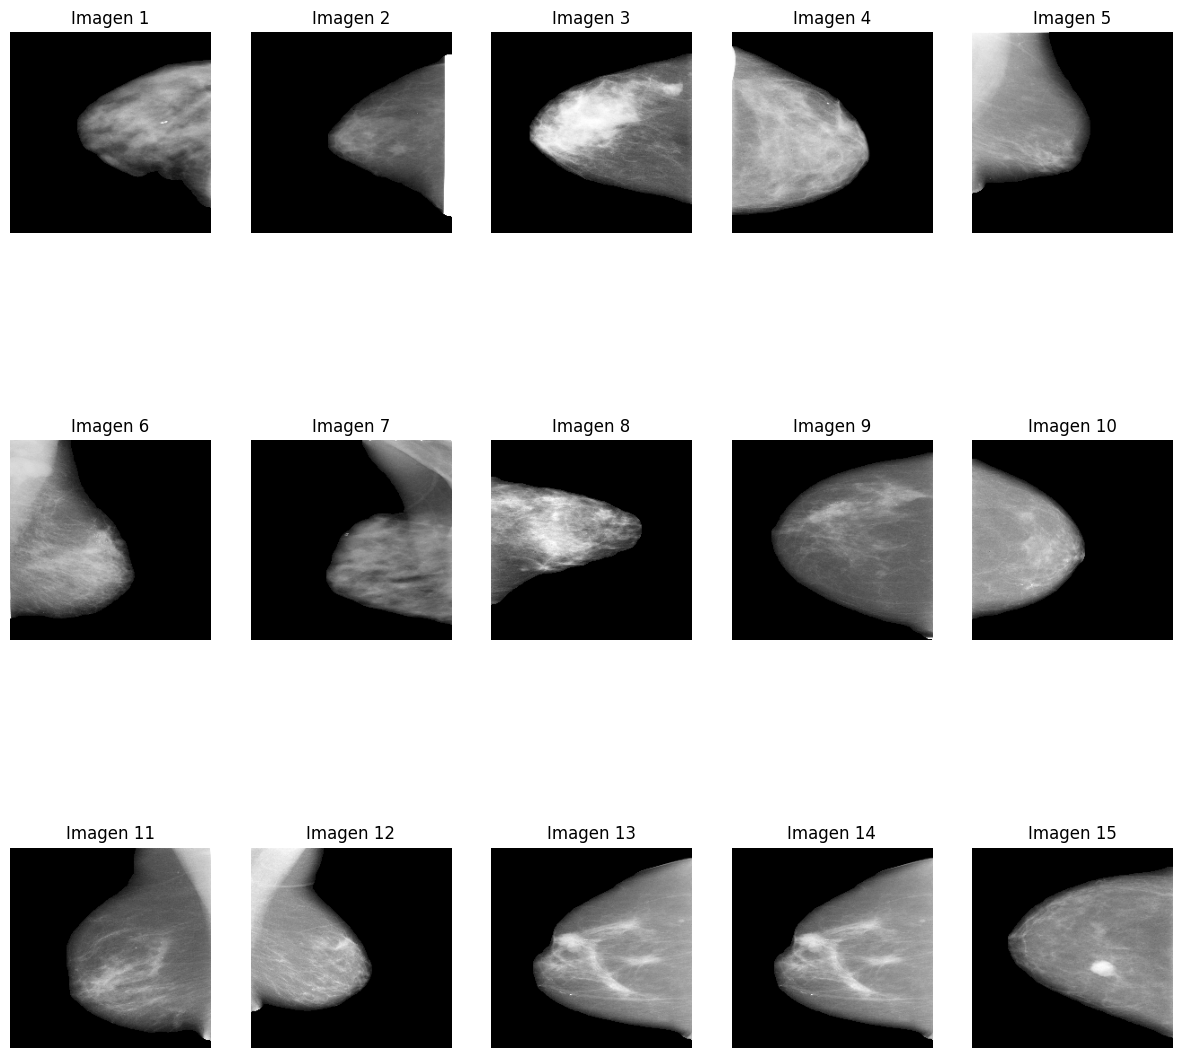

In [53]:
import matplotlib.pyplot as plt

# Función para mostrar imágenes
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Muestra la imagen y establece el título
            ax.imshow(images[i].numpy().squeeze(), cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')  # Desactiva los ejes
        else:
            ax.axis('off')  # Desactiva los ejes de los subplots vacíos

# Títulos para las imágenes
titles = ['Imagen ' + str(i+1) for i in range(15)]

# Graficar las primeras 15 imágenes
plot_images(image_data[2000:2015], titles, rows=3, cols=5)

plt.show()


Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [54]:
unique_labels, unique_counts = np.unique(labels, return_counts=True)

# Crea un diccionario con las etiquetas y sus conteos
labels_histogram = dict(zip(unique_labels, unique_counts))

print(labels_histogram)

{1: 1995, 2: 1406}


In [55]:
image_data = np.array(image_data)
labels = np.array(labels)



X_train=[]
X_test=[]
y_train=[]
y_test = []



In [202]:
######### por si se prueba con transfer learning
#imagenes_rgb = []
#for imagen_gris in image_data:
    # Convertir la imagen de escala de grises a RGB
    #imagen_rgb = cv2.cvtColor(imagen_gris, cv2.COLOR_GRAY2RGB)
    # Agregar la imagen convertida a la lista
    #imagenes_rgb.append(imagen_rgb)
#imagenes_rgb = np.array(imagenes_rgb)

In [56]:

# Dividir en conjuntos de entrenamiento (70%) y temporal (30%), manteniendo el balance de etiquetas
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.3, stratify=labels, random_state=42)

# Dividir el conjunto temporal en validación y prueba, manteniendo el balance de etiquetas
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

from collections import Counter 
# Verificar las proporciones en los conjuntos de entrenamiento, validación y prueba
print("Proporciones en el conjunto de entrenamiento:", Counter(y_train))
print("Proporciones en el conjunto de validación:", Counter(y_val))
print("Proporciones en el conjunto de prueba:", Counter(y_test))


Proporciones en el conjunto de entrenamiento: Counter({1: 1396, 2: 984})
Proporciones en el conjunto de validación: Counter({1: 299, 2: 211})
Proporciones en el conjunto de prueba: Counter({1: 300, 2: 211})


In [57]:
print(type(X_train))

<class 'numpy.ndarray'>


In [58]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2380, 224, 224)
Forma de X_val: (510, 224, 224)
Forma de X_test: (511, 224, 224)
Forma de y_train: (2380,)
Forma de y_val: (510,)
Forma de y_test: (511,)


In [59]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val,axis=-1)


# Verifica las nuevas formas
print(f"Nueva forma de datos de entrenamiento: {X_train.shape}")
print(f"Nueva forma de datos de prueba: {X_test.shape}")
print(f"Nueva forma de datos de validacion: {X_test.shape}")

Nueva forma de datos de entrenamiento: (2380, 224, 224, 1)
Nueva forma de datos de prueba: (511, 224, 224, 1)
Nueva forma de datos de validacion: (511, 224, 224, 1)


In [60]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# Restar 1 a las etiquetas para que empiecen en 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1
y_val_adjusted = y_val - 1

# Convertir las etiquetas a codificación one-hot
y_train_one_hot = to_categorical(y_train_adjusted, num_classes=2)
y_test_one_hot = to_categorical(y_test_adjusted, num_classes=2)
y_val_one_hot = to_categorical(y_val_adjusted, num_classes=2)

# Crear generadores de datos de imagen con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255  # Reescala las imágenes por el factor dado
)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Crear generadores que suministrarán los datos al modelo durante el entrenamiento
train_generator = train_datagen.flow(
    X_train,
    y_train_one_hot,
    batch_size=32
)

test_generator = test_datagen.flow(
    X_test,
    y_test_one_hot,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val,
    y_val_one_hot,
    batch_size=32
)


In [61]:
print(y_val)

[1 1 1 1 2 1 2 1 2 1 2 1 2 2 1 1 2 2 1 2 1 1 2 1 1 1 2 1 1 1 2 1 1 2 1 2 1
 1 2 2 2 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 2 1 2 1 1 2 1 1 1 2 2 1 2 1 2
 1 1 1 1 1 1 2 1 2 2 1 2 2 1 1 1 1 2 1 2 1 2 2 2 1 1 2 2 2 2 1 1 1 2 1 2 1
 2 1 1 1 1 2 2 1 2 1 1 1 1 2 1 2 1 2 1 1 2 2 1 2 2 2 1 1 1 1 1 2 1 1 2 1 1
 1 1 1 2 1 2 2 1 1 2 2 2 2 2 2 2 2 2 1 1 2 1 2 1 1 1 1 2 1 2 2 1 1 2 1 2 2
 1 1 1 1 1 2 1 1 1 2 2 2 2 1 1 2 1 2 1 1 1 1 2 2 1 1 1 2 2 1 1 2 1 2 1 1 1
 1 2 2 1 1 2 1 2 2 1 2 2 1 1 1 2 2 1 1 1 2 1 1 1 1 2 2 2 1 2 1 1 1 2 1 1 2
 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 2 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 1 1 1
 2 1 2 1 2 1 1 1 1 1 1 2 2 1 1 1 2 2 2 1 1 1 1 2 1 2 2 1 2 2 2 2 1 1 1 2 1
 2 1 1 1 2 1 2 1 2 2 1 1 1 2 2 1 1 1 1 2 2 1 1 2 1 1 2 1 1 2 1 2 1 1 2 1 2
 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 2 2 1 2 2 2 1 2 1 1 2 2 2 2 2 1 2 2 2 2 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 2 2 1 2 1 1 2 2 1 1 2 1 2 1 2 1 1 2 2 1 2 1 2 1 1
 1 2 2 2 1 2 1 2 2 2 1 1 1 1 1 2 2 2 2 2 1 1 1 2 1 2 2 2 2 2 2 1 1 1 1 1 1
 2 2 1 1 1 1 1 1 2 1 2 2 

In [62]:
print("GPUs disponibles: ", tf.config.list_physical_devices('GPU'))

GPUs disponibles:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [63]:
#Early stopping para que se detenga el entranamiento si a las 5 épocas no mejora el accuracy

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)


In [64]:

# callback para detener el entrenamiento si se alcanza el accuracy deseado
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("Accuracy alcanzado")
      self.model.stop_training = True


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

model = Sequential()

# Agregar la primera capa convolucional
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 1)))

model.add(Conv2D(64, (3, 3), activation='relu'))
# Agregar la primera capa de MaxPooling
model.add(MaxPooling2D((2, 2)))

# Agregar la segunda capa convolucional
model.add(Conv2D(128, (3, 3),  activation='relu'))

# Agregar dos capas convolucionales más
for _ in range(1):
    model.add(Conv2D(128, (3, 3), activation='relu'))

# Agregar la segunda capa de MaxPooling
model.add(MaxPooling2D((2, 2)))

# Agregar tres capas convolucionales más
for _ in range(2):
    model.add(Conv2D(256, (3, 3), activation='relu'))

model.add(MaxPooling2D((2, 2)))

# Utilizar GlobalAveragePooling2D en lugar de Flatten
model.add(GlobalAveragePooling2D())

# Agregar una capa completamente conectada (Fully Connected) con 256 neuronas
model.add(Dense(256, activation='relu'))

# Agregar la capa de salida con 2 neuronas (para la clasificación binaria)
model.add(Dense(2, activation='sigmoid'))

# Resumen del modelo
model.summary()


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 222, 222, 64)      640       
                                                                 
 conv2d_139 (Conv2D)         (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_140 (Conv2D)         (None, 108, 108, 128)     73856     
                                                                 
 conv2d_141 (Conv2D)         (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                

In [98]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [99]:
stop = myCallback()
with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        epochs=30,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=[early_stopping,stop])

Epoch 1/30


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_25/conv2d_138/Relu' defined at (most recent call last):
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\andre\AppData\Local\Temp\ipykernel_25288\3733523635.py", line 3, in <module>
      history = model.fit(train_generator,
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\andre\anaconda3\envs\entornoPy\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'sequential_25/conv2d_138/Relu'
OOM when allocating tensor with shape[32,222,222,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_25/conv2d_138/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_291358]

In [72]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

16/16 [==============================] - 1s 38ms/step - loss: 0.6793 - accuracy: 0.5871
Test Accuracy: 0.587084174156189


In [216]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [217]:
# Visualización de curvas de pérdida y precisión
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    
    plt.show()

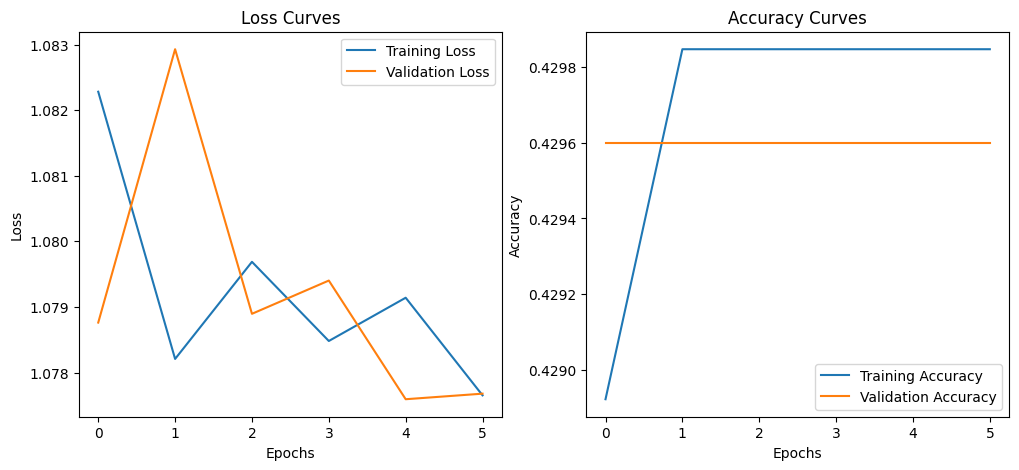

In [218]:
plot_training_history(history)

In [219]:
from sklearn.metrics import roc_curve, auc, recall_score,f1_score
import matplotlib.pyplot as plt

# Use the trained model to predict probabilities for the test set
y_pred_prob = model.predict(X_test)

# Convert y_pred_prob to a 1-dimensional array if it's 2-dimensional with only one column
if y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Print the AUC score
print(f'AUC: {roc_auc:.2f}')


22/22 [==============================] - 0s 5ms/step


ValueError: multiclass format is not supported

116/116 [==============================] - 0s 4ms/step
Matriz de Confusión:
[[1213  397]
 [ 412 1665]]


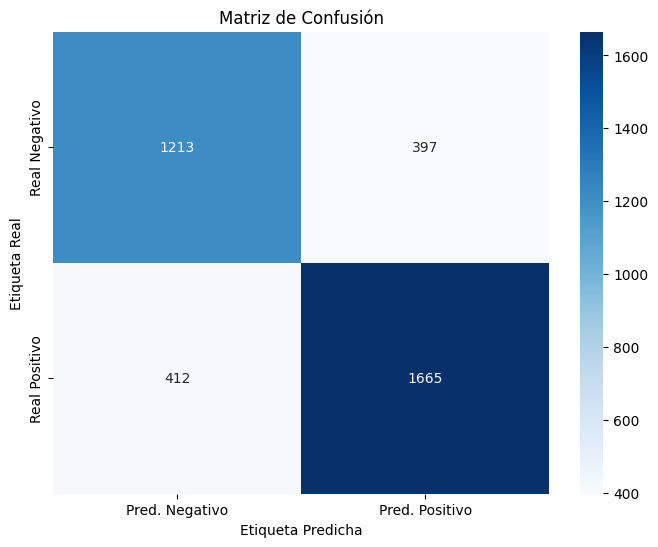

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_prob = model.predict(X_test)

# Paso 4: Convierte las probabilidades en etiquetas de clase usando un umbral de 0.5
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)

# Paso 5: Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Paso 6: Muestra la matriz de confusión
print("Matriz de Confusión:")
print(conf_matrix)

# Paso 7: Visualiza la matriz de confusión usando una gráfica de calor (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred. Negativo', 'Pred. Positivo'], yticklabels=['Real Negativo', 'Real Positivo'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Calcular recall y F-score
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Recall: 0.80
F1-score: 0.80
